# Named Entity Recognition

## Data

In [1]:
import pandas as pd
import numpy as np
import pymongo
from pprint import pprint

from collections import defaultdict
import json

In [2]:
client = pymongo.MongoClient('localhost', 27017)
db = client["news"]
data = db["data"]

## Model

In [3]:
import flair, torch
from flair.models import SequenceTagger
from flair.tokenization import SegtokSentenceSplitter
from flair.data import Sentence

/home/scurrra/Programs/Anaconda/envs/nlp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Fri Feb 17 09:08:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P8    N/A /  N/A |      6MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
flair.device = torch.device("cuda:0")

In [7]:
splitter = SegtokSentenceSplitter()
#tagger = SequenceTagger.load('ner')
tagger = SequenceTagger.load('ner-fast')

2023-02-17 09:08:27,925 loading file /home/scurrra/.flair/models/ner-english-fast/4c58e7191ff952c030b82db25b3694b58800b0e722ff15427f527e1631ed6142.e13c7c4664ffe2bbfa8f1f5375bd0dced866b8c1dd7ff89a6d705518abf0a611


/home/scurrra/Programs/Anaconda/envs/nlp/lib/python3.8/site-packages/huggingface_hub/file_download.py:629: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-02-17 09:08:29,762 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [8]:
stats = {
    "last_new_indx": -1,
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}

In [10]:
def ner_eval(stats: dict, new: dict):
    splitted = splitter.split(new["content"])
    splitted.append(Sentence(new["title"]))
    if isinstance(new["description"], str):
        splitted.extend(
            splitter.split(new["description"])
        )

    tagger.predict(splitted)

    buf_stats = {
        "PER":  defaultdict(int),
        "LOC":  defaultdict(int),
        "ORG":  defaultdict(int),
        "MISC": defaultdict(int)
    }     # костыль

    # число вхождений в текст
    for sentence in splitted:
        for entity in sentence.get_spans("ner"):
            #print(entity)
            buf_stats[entity.tag][entity.text] += 1 

    for key in buf_stats.keys():
        for entity in buf_stats[key].keys():
            stats[key][entity].append((new["index"], buf_stats[key][entity]))

In [3]:
ner_stats = db["ner_stats"]
# ner_stats.insert_one(stats)

ner_stats__sa_full = db["ner_stats__sa_full"]
# ner_stats__sa_full.insert_one({
#     "PER":  defaultdict(list),
#     "LOC":  defaultdict(list),
#     "ORG":  defaultdict(list),
#     "MISC": defaultdict(list)
# })

### Test on one of the news

In [11]:
stats = {
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}

In [12]:
new_test = data.find_one({"index": 4712})
new_test;

In [13]:
test_splitted = splitter.split(new_test["content"])
test_splitted.append(Sentence(new_test["title"]))
if isinstance(new_test["description"], str):
    test_splitted.extend(
        splitter.split(new_test["description"])
    )

test_splitted

[Sentence: "( CNN ) Right now , there 's a shortage of truck drivers in the US and worldwide , exacerbated by the e-commerce boom brought on by the pandemic .",
 Sentence: "One solution to the problem is autonomous trucks , and several companies are in a race to be the first to launch one .",
 Sentence: "Among them is San Diego-based TuSimple.Founded in 2015 , TuSimple has completed about 2 million miles of road tests with its 70 prototype trucks across the US , China and Europe .",
 Sentence: "Although these are simply commercially available trucks retrofitted with its technology , TuSimple has deals in place with two of the world 's largest truck manufacturers -- Navistar in the US and Traton , Volkswagen 's trucking business , in Europe -- to design and build fully autonomous models , which it hopes to launch by 2024 .",
 Sentence: "Photos : The Yara Birkeland is what its builders call the world 's first zero-emission , autonomous cargo ship .",
 Sentence: "The ship is scheduled to 

In [14]:
tagger.predict(test_splitted)

In [15]:
test_splitted[0].get_spans("ner")[0].get_label()

'Span[15:16]: "US"'/'LOC' (0.999)

In [16]:
test_splitted[0].get_spans("ner")[0].text

'US'

In [17]:
test_splitted[0].get_spans("ner")[0].tag

'LOC'

In [18]:
test_splitted[0].get_spans("ner")[0].score

0.9989510774612427

In [19]:
INDX = 4712

In [20]:
buf_stats = {
    "PER":  defaultdict(list),
    "LOC":  defaultdict(list),
    "ORG":  defaultdict(list),
    "MISC": defaultdict(list)
}     # костыль

for sentence in test_splitted:
    for entity in sentence.get_spans("ner"):
        #print(entity)
        buf_stats[entity.tag][entity.text].append(1) 

for key in buf_stats.keys():
    for entity in buf_stats[key].keys():
        stats[key][entity].append((INDX, sum(buf_stats[key][entity])))
    print(key)
    pprint(stats[key])

stats

PER
defaultdict(<class 'list'>,
            {'Cheng Lu': [(4712, 1)],
             'Grayson Brulte': [(4712, 1)],
             'Lu': [(4712, 9)],
             'Steve Lee': [(4712, 1)],
             'Stretch': [(4712, 1)],
             'TuSimple': [(4712, 2)]})
LOC
defaultdict(<class 'list'>,
            {'Arizona': [(4712, 2)],
             'Aurora': [(4712, 1)],
             'Boston': [(4712, 1)],
             'China': [(4712, 5)],
             'Dallas': [(4712, 1)],
             'Denmark': [(4712, 1)],
             'Dubai': [(4712, 1)],
             'El Paso': [(4712, 1)],
             'Europe': [(4712, 3)],
             'Germany': [(4712, 1)],
             'London': [(4712, 1)],
             'Maglev': [(4712, 1)],
             'Netherlands': [(4712, 1)],
             'Nogales': [(4712, 1)],
             'Oklahoma City': [(4712, 1)],
             'Phoenix': [(4712, 1)],
             'Qingdao': [(4712, 1)],
             'Shandong Province': [(4712, 1)],
             'Sharjah': [(4712,

{'PER': defaultdict(list,
             {'Steve Lee': [(4712, 1)],
              'Cheng Lu': [(4712, 1)],
              'TuSimple': [(4712, 2)],
              'Lu': [(4712, 9)],
              'Stretch': [(4712, 1)],
              'Grayson Brulte': [(4712, 1)]}),
 'LOC': defaultdict(list,
             {'US': [(4712, 9)],
              'China': [(4712, 5)],
              'Europe': [(4712, 3)],
              'Maglev': [(4712, 1)],
              'Qingdao': [(4712, 1)],
              'Shandong Province': [(4712, 1)],
              'Netherlands': [(4712, 1)],
              'UAE': [(4712, 1)],
              'Sharjah': [(4712, 1)],
              'Dubai': [(4712, 1)],
              'Germany': [(4712, 1)],
              'Nogales': [(4712, 1)],
              'Arizona': [(4712, 2)],
              'Oklahoma City': [(4712, 1)],
              'Tucson': [(4712, 1)],
              'Dallas': [(4712, 1)],
              'TuSimple': [(4712, 2)],
              'Texas': [(4712, 1)],
              'Phoenix': [

## Evaluating

In [26]:
from tqdm import tqdm

### SA-Full dataset

In [26]:
sa_full_indx = sorted([_["index"] for _ in db["sa_full"].find()])

In [27]:
stats__sa_full = list(ner_stats__sa_full.find())[-1]

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats__sa_full[key] = defaultdict(list, stats__sa_full[key])

{key: len(stats__sa_full[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 2409, 'LOC': 630, 'ORG': 895, 'MISC': 1100}

In [28]:
samples = data.find({"index": {"$in": sa_full_indx}})

In [27]:
ner_samples_failed__sa_full = []
for new in tqdm(samples, total=len(sa_full_indx)):
    try:
        ner_eval(stats__sa_full, new)
    except:
        ner_samples_failed__sa_full.append(new["index"])
print(ner_samples_failed__sa_full)

100%|██████████| 97/97 [03:17<00:00,  2.03s/it]

[]


In [33]:
{key: len(stats__sa_full[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 2409, 'LOC': 630, 'ORG': 895, 'MISC': 1100}

In [29]:
ner_stats__sa_full.update_one({"_id": stats__sa_full["_id"]}, {"$set": stats__sa_full})

### Full dataset

In [6]:
stats = list(ner_stats.find())[-1]

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats[key] = defaultdict(list, stats[key])

{key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 27780, 'LOC': 7065, 'ORG': 18536, 'MISC': 11428}

In [7]:
del stats["_id"]
stats_json = json.dumps(stats)

with open("data/stats.json", "w") as stats_file:
    stats_file.write(stats_json)

In [5]:
N_SAMPLES = 1000

In [48]:
samples = data.find({"index": {"$gt": stats["last_new_indx"], "$lte": stats["last_new_indx"]+N_SAMPLES}})

In [49]:
ner_samples_failed = []
for new in tqdm(samples, total=N_SAMPLES):
    try:
        ner_eval(stats, new)
    except:
        ner_samples_failed.append(new["index"])
stats["last_new_indx"] += N_SAMPLES
print(ner_samples_failed)

100%|██████████| 1000/1000 [26:21<00:00,  1.58s/it]

[5295]


In [50]:
stats["last_new_indx"]

5999

In [51]:
{key: len(stats[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

{'PER': 27780, 'LOC': 7065, 'ORG': 18536, 'MISC': 11428}

In [52]:
ner_stats.update_one({"_id": stats["_id"]}, {"$set": stats})

In [30]:
# ner_stats.remove({"_id": stats["_id"]})

## Analysis

In [76]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt

In [61]:
sa_full_indx = sorted([_["index"] for _ in db["sa_full"].find()])

stats__sa_full = list(ner_stats__sa_full.find())[-1]

for key in ["PER", "LOC", "ORG", "MISC"]:
    stats__sa_full[key] = defaultdict(list, stats__sa_full[key])

{key: len(stats__sa_full[key]) for key in ["PER", "LOC", "ORG", "MISC"]}

news = {
    news["index"]: news
    for news in data.find({"index": {"$in": sa_full_indx}})
}

In [45]:
st = stats__sa_full

In [46]:
top = {
    "PER": sorted(st["PER"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10],
    "ORG": sorted(st["ORG"].items(), key=lambda ent: len(ent[1]), reverse=True)[1:6], # because the 1st was `CNN` in the beginning of among each new
    "LOC": sorted(st["LOC"].items(), key=lambda ent: len(ent[1]), reverse=True)[:10],
}

{key: len(top[key]) for key in ["PER", "LOC", "ORG"]}

{'PER': 10, 'LOC': 10, 'ORG': 5}

### `PER`

In [53]:
def get_stats_from_dict(ent: tuple, st=0):
    return [_[st] for _ in ent[1]]

Для топ-10 самых популярных персон из вашего датасета составьте список статей, в которых они упоминались. Результаты можно вывести в виде json-файла (person → list of articles’ titles).

In [62]:
{
    person[0]: [
        news[news_id]["title"]
        for news_id in get_stats_from_dict(person)
    ]
    for person in top["PER"]
}

{'Joe Biden': ["Opinion: What Biden's top economic priority must be - CNN",
  "Read: Former President Donald Trump's January 6 speech - CNNPolitics",
  'Biden to speak with Chinese President Xi Jinping Friday - CNNPolitics',
  "Justice Department to investigate Minneapolis policing practices after George Floyd's death - CNNPolitics",
  'Texas National Guard soldier dies after a firearm discharged accidentally\n \n - CNN',
  'White House clamps down on federal cybersecurity after big hacks - CNNPolitics',
  "Russian prisoners of war in Ukraine voice disquiet, shame over war. 'We all will be judged.'  - CNN"],
 'Donald Trump': ['The polite way to call someone a racist - CNN',
  "Read: Former President Donald Trump's January 6 speech - CNNPolitics",
  'W. Kamau Bell: My megachurch adventure (opinion)  - CNN',
  'Trump announces new intel chief pick; No. 2 intelligence official is leaving administration - CNNPolitics',
  'Marine Le Pen declares candidacy for French presidency - CNN',
  "A 

Составьте графики упоминания топ-3 популярных персон за весь временной промежуток, который представлен в ваших данных.

In [75]:
PER_dates = {
    person[0]: [
        news[news_id]["date"]
        for news_id in get_stats_from_dict(person)
    ]
    for person in top["PER"][:3]
}

In [97]:
top["PER"][0][0]

True

In [96]:
[_[0] for _ in top["PER"][:3]]

['Joe Biden', 'Donald Trump', 'Barack Obama']

In [99]:
# @interact(
#     person=widgets.Dropdown(option=[_[0] for _ in top["PER"][:3]], value=top["PER"][0][0], description="Person")
# )
# def density_plot(person: str):
#     print(PER_dates[person])

In [103]:
persons = list(PER_dates.keys())
persons

['Joe Biden', 'Donald Trump', 'Barack Obama']

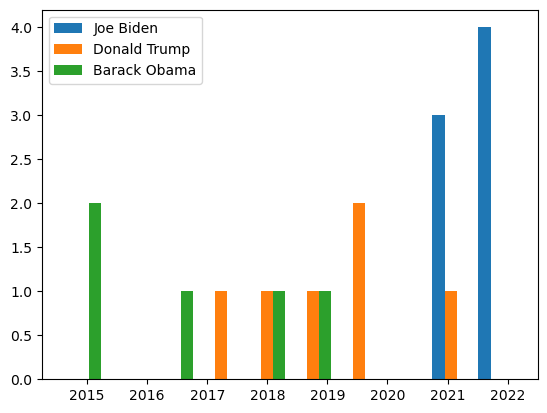

In [116]:
plt.hist(
    list(PER_dates.values())
);
plt.legend(persons);

### `ORG`

Какая организация оказалась самой “популярной” в ваших данных? Какие организации вошли в топ-5 по популярности? 

In [71]:
[_[0] for _ in top["ORG"]]

['Twitter', 'CNNPolitics', 'EU', 'Facebook', 'NBA']

Для топ-5 самых популярных организаций из вашего датасета составьте список статей, в которых они упоминались. Результаты можно вывести в виде json-файла (organization → list of articles’ titles).

In [72]:
{
    org[0]: [
        news[news_id]["title"]
        for news_id in get_stats_from_dict(org)
    ]
    for org in top["ORG"]
}

{'Twitter': ['W. Kamau Bell: My megachurch adventure (opinion)  - CNN',
  'Trump announces new intel chief pick; No. 2 intelligence official is leaving administration - CNNPolitics',
  "A Puerto Rican man sued Georgia for discriminatory driver's license policies. Now the state is making changes - CNN",
  "'American Dirt,' Oprah's new book club pick, is fueling a debate over who gets to tell which stories - CNN",
  'NFL warns players of contaminated meat in Mexico, China - CNN',
  'Dutch church clocks up 1,400 hours to prevent family being deported - CNN',
  'Brexit vote delayed as Theresa May pulls the plug - CNN',
  "Jon Jones was charged with battery from an incident in April, but he didn't know until July  - CNN",
  "Hungary's parliament votes to let Viktor Orban rule by decree in wake of coronavirus pandemic  - CNN"],
 'CNNPolitics': ["Read: Former President Donald Trump's January 6 speech - CNNPolitics",
  "Full 'Putin list' of Russian oligarchs and politicians - CNNPolitics",
  '

### `LOC`

Найдите топ-10 локаций, упомянутых в новостях за тот период, что представлен в вашем датасете. Для топ-5 самых популярных из них составьте составьте список статей, в которых они упоминались. Результаты можно вывести в виде json-файла (location → list of articles’ titles).

In [73]:
[_[0] for _ in top["LOC"]]

['US',
 'United States',
 'France',
 'London',
 'Russia',
 'New York',
 'U.S.',
 'Spain',
 'Germany',
 'Europe']

In [74]:
{
    loc[0]: [
        news[news_id]["title"]
        for news_id in get_stats_from_dict(loc)
    ]
    for loc in top["ORG"][:5]
}

{'Twitter': ['W. Kamau Bell: My megachurch adventure (opinion)  - CNN',
  'Trump announces new intel chief pick; No. 2 intelligence official is leaving administration - CNNPolitics',
  "A Puerto Rican man sued Georgia for discriminatory driver's license policies. Now the state is making changes - CNN",
  "'American Dirt,' Oprah's new book club pick, is fueling a debate over who gets to tell which stories - CNN",
  'NFL warns players of contaminated meat in Mexico, China - CNN',
  'Dutch church clocks up 1,400 hours to prevent family being deported - CNN',
  'Brexit vote delayed as Theresa May pulls the plug - CNN',
  "Jon Jones was charged with battery from an incident in April, but he didn't know until July  - CNN",
  "Hungary's parliament votes to let Viktor Orban rule by decree in wake of coronavirus pandemic  - CNN"],
 'CNNPolitics': ["Read: Former President Donald Trump's January 6 speech - CNNPolitics",
  "Full 'Putin list' of Russian oligarchs and politicians - CNNPolitics",
  '